In [1]:
import sys
sys.path.insert(0, '../python')

import cool_tigress as ct

## Calculate equilibrium cooling curve and pickle

In [8]:
Zs = np.array([0.1, 0.5, 1.0, 2.0])
G0s = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])
xi_CRs = 2e-16*np.sqrt(G0s)

Tmin = 10.0
Tmax = 10.0**4.1
T = np.logspace(np.log10(Tmin), np.log10(Tmax), num=200)
par = dict(T=T, Z=1.0, xi_CR=2e-16,
           G_PE=1.0, G_CI=1.0, G_CO=1.0, G_H2=1.0,
           x_e_init=0.03, equil=True, maxiter=400, fast_flag=False)

#Zs = np.array([0.1, 0.5, 1.0, 2.0])
Zs = np.array([1.0])
#G0s = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]) # extreme
#G0s = np.array([1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0, 1e1]) # normal
G0s = np.array([1e-1]) # normal
xi_CRs = 2e-16*np.sqrt(G0s)
#xi_CRs = 2e-16*G0s

par_iter = ((Z, xi_CR, G0) for Z in Zs for xi_CR, G0 in zip(xi_CRs, G0s))
#par_iter = ((Z, xi_CR, G0) for Z in Zs for xi_CR in xi_CRs for G0 in G0s)

# for p in par_iter:
#     print(p)

for i, (Z, xi_CR, G0) in enumerate(par_iter):
    print(i, Z, xi_CR, G0)
    par.update(Z=Z, xi_CR=xi_CR, G_PE=G0, G_CI=G0, G_CO=G0, G_H2=G0, fast_flag=False)
    c = ct.CoolTigress(**par)
    c.save()
    par.update(fast_flag=True)
    c = ct.CoolTigress(**par)
    c.save()

0 1.0 6.324555320336759e-17 0.1
pickled to  ./cool_tigress_pickle/cool_equil_xi6.3e-17_GPE0.1_Z1.p
pickled to  ./cool_tigress_pickle/cool_equil_xi6.3e-17_GPE0.1_Z1_fast.p


# Plot results

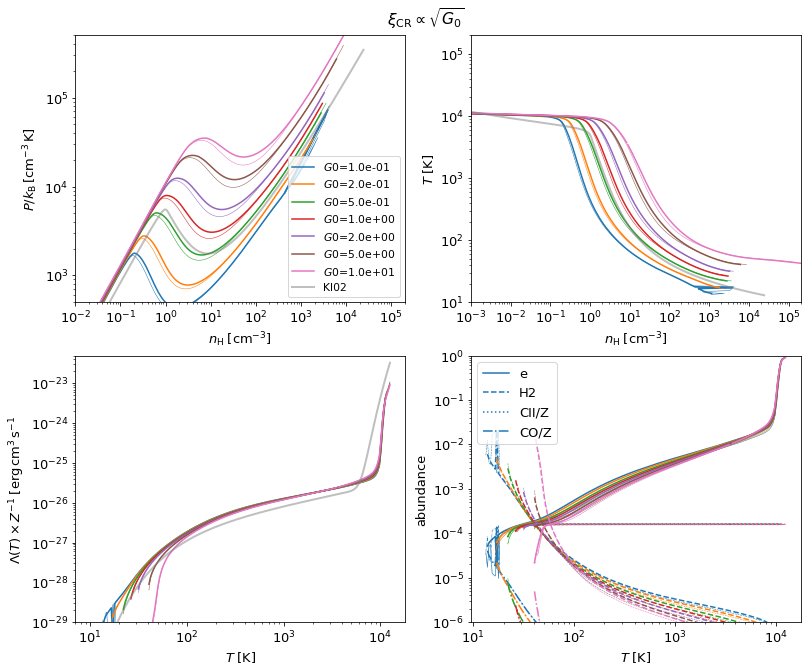

In [9]:
import cmocean

Tmin = 10.0
Tmax = 10.0**4.1
T = np.logspace(np.log10(Tmin), np.log10(Tmax), num=200)
par = dict(T=T, Z=1.0, xi_CR=2e-16,
           G_PE=1.0, G_CI=1.0, G_CO=1.0, G_H2=1.0,
           x_e_init=0.03, equil=True, maxiter=200, fast_flag=False)
c = ct.CoolTigress(**par)

def plt_cool_tigress(axes, r, Z, **plt_sty):
    plt.sca(axes[0])
    l, = plt.loglog(r['nH'], r['pok'], **plt_sty)
    plt.sca(axes[1])
    plt.loglog(r['nH'], r['T'], **plt_sty)
    plt.sca(axes[2])
    plt.loglog(r['T'], r['cooling']/Z, **plt_sty)
    plt.sca(axes[3])
    plt.loglog(r['T'], r['x_e'], ls='-', **plt_sty)
    plt.loglog(r['T'], r['x_H2'], ls='--', **plt_sty)
    plt.loglog(r['T'], r['x_Cplus']/Z, ls=':', **plt_sty)
    plt.loglog(r['T'], r['x_CO']/Z, ls='-.', **plt_sty)
    
mpl.rcParams['font.size'] = 13
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
axes = axes.flatten()

#cmap = cmocean.cm.thermal
#norm = mpl.colors.LogNorm(0.1, 2.0)
#colors = [cmap(norm(Z)) for Z in Zs]

#opt = 'Z'
#opt = 'G0'
opt = 'G0sqrtCR'
opt_G0 = 'normal'
#opt_G0 = 'extreme'
Z = 1.0
if opt == 'Z':
    v = np.array([0.1, 0.5, 1.0, 2.0])
    par.update(xi_CR=2e-16, G_PE=1.0, G_CI=1.0, G_CO=1.0, G_H2=1.0)
elif opt == 'G0' or opt == 'G0sqrtCR':
    if opt_G0 == 'extreme':
        v = np.array([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]) # Extreme
    else:
        v = np.array([1e-1, 2e-1, 5e-1, 1e0, 2e0, 5e0, 1e1]) # normal galaxies
    
    par.update(Z=Z)
    
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
for v_, color in zip(v, colors):
    if opt == 'Z':
        c.Z = v_
        plt_sty = dict(c=color, label=r'$Z$={0:.1g}'.format(v_))
    elif opt == 'G0' or opt == 'G0sqrtCR':
        c.G_PE = v_
        c.G_CI = v_
        c.G_CO = v_
        c.G_H2 = v_
        if opt == 'G0sqrtCR':
            c.xi_CR = 2e-16*np.sqrt(v_)
        else:
            c.xi_CR = 2e-16*v_
        plt_sty = dict(c=color, label=r'$G0$={0:.1e}'.format(v_))
    
    c.fast_flag = False
    r = c.load()
    if opt == 'Z':
        Z = v_
    plt_cool_tigress(axes, r, Z, **plt_sty)

    c.fast_flag = True
    r = c.load()
    plt_sty = dict(lw=0.5, alpha=1.0, c=color, label='_nolegend_'.format(Z))
    plt_cool_tigress(axes, r, Z, **plt_sty)
    
import KI02
cf = KI02.coolftn()
mu=cf.temp/cf.T1
G0 = 1.0
heat1 = cf.heat[0]*((mu - mu.min())/(mu.max() - mu.min()))*(G0 + 0.0024)
#den = heat1/cf.cool
nH_ = cf.heat/cf.cool
muH = 1.4271
axes[0].loglog(nH_, muH*cf.T1*nH_, c='grey', lw=2, alpha=0.5, label='KI02')    

axes[0].set_xlim(1e-2, 2e5)
axes[0].set_ylim(5e2, 5e5)
axes[0].set_xlabel(r'$n_{\rm H}\;[{\rm cm}^{-3}]$')
axes[0].set_ylabel(r'$P/k_{\rm B}\,[\rm cm^{-3}\,{\rm K}]$')
axes[0].legend(loc=4, fontsize='small')

axes[1].set_xlim(1e-3, 2e5)
axes[1].set_ylim(1e1, 2e5)
axes[1].loglog(nH_, cf.temp, c='grey', lw=2, alpha=0.5, label='KI02')
axes[1].set_xlabel(r'$n_{\rm H}\;[{\rm cm}^{-3}]$')
axes[1].set_ylabel(r'$T\;[{\rm K}]$')

# Oplot Koyama & Inutsuka
cool_KI = lambda T: 2e-26*(1e7*np.exp(-1.184e5/(T + 1000.0)) + 1.4e-2*np.sqrt(T)*np.exp(-92.0/T))
axes[2].plot(T, cool_KI(T), c='grey', lw=2, alpha=0.5, label='KI02')
#axes[2].legend()
axes[2].set_xlabel(r'$T\;[{\rm K}]$')
axes[2].set_ylabel(r'$\Lambda(T)\times Z^{-1}\;[{\rm erg}\,{\rm cm}^{3}\,{\rm s}^{-1}$')
axes[2].set_ylim(1e-29, 5e-23)

axes[3].set_xlabel(r'$T\;[{\rm K}]$')
axes[3].set_ylabel(r'abundance')
axes[3].set_ylim(1e-6, 1)
axes[3].legend([mpl.lines.Line2D([0],[0], ls='-'),
                mpl.lines.Line2D([0],[0], ls='--'),
                mpl.lines.Line2D([0],[0], ls=':'),
                mpl.lines.Line2D([0],[0], ls='-.')],
                ['e','H2','CII/Z', 'CO/Z'], loc=2)

if opt == 'G0sqrtCR':
    plt.suptitle(r'$\xi_{\rm CR}\propto \sqrt{G_0}$')
elif opt == 'G0':
    plt.suptitle(r'$\xi_{\rm CR}\propto G_0$')
elif opt == 'Z':
    plt.suptitle(r'$\xi_{\rm CR}=2e-16,\,G_0=1$')
plt.subplots_adjust(top=0.94)

if opt == 'Z':
    plt.savefig('../figure/equil_{0:s}.png'.format(opt), dpi=200)
else:
    plt.savefig('../figure/equil_{0:s}_{1:s}_Z{2:.1g}.png'.format(opt, opt_G0, Z), dpi=200)

In [16]:
r.keys()

dict_keys(['nH', 'T', 'Z', 'Z_g', 'Z_d', 'xi_CR', 'dvdr', 'G_PE', 'G_CI', 'G_CO', 'G_H2', 'fast_flag', 'par', 'x_e_init', 'maxiter', 'x_e', 'x_HI', 'x_H2', 'x_Cplus', 'x_CI', 'x_CO', 'x_OI', 'cooling', 'Lambda', 'heating', 'Gamma', 'pok'])

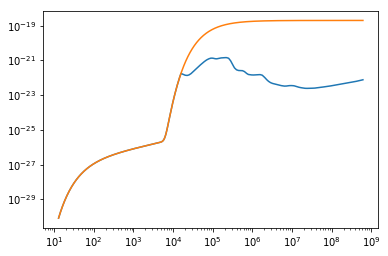

In [52]:
import KI02
cf = KI02.coolftn()
mu=cf.temp/cf.T1
# # G0prime == 1.0 when Sigma_FUV = 6.9 Lsun / pc**2
G0 = 1.0
heat1 = cf.heat[0]*((mu - mu.min())/(mu.max() - mu.min()))*(G0 + 0.0024)
nden = cf.heat/cf.cool
nden1 = heat1/cf.cool
#plt.loglog(nden, cf.T1*nden)
plt.loglog(cf.temp, cf.cool)
plt.loglog(cf.temp, cool_KI(cf.temp))

In [63]:
c.load()

TypeError: load() missing 3 required positional arguments: 'xi_CR', 'G_PE', and 'Z'

In [46]:
d = dict()
for k in c.__dict__.keys():
    d[k] = getattr(c, k)
#     if isinstance(getattr(c, k), (np.ndarray, np.generic)):
#         print(v, type(getattr(c, k)))
#         d[str(
#     else:
#         print(v,getattr(c, v))
d

{'nH': array([4.84116839e+02, 4.56709331e+02, 4.32530101e+02, 2.19557601e+04,
        3.88655016e+02, 3.68142024e+02, 3.48319069e+02, 3.29016858e+02,
        3.10201765e+02, 2.91736921e+02, 2.73596038e+02, 2.55785767e+02,
        2.38329247e+02, 2.21218283e+02, 2.04485238e+02, 1.88142243e+02,
        1.72313768e+02, 1.57070784e+02, 1.42524454e+02, 1.28753295e+02,
        1.16222757e+02, 1.04619308e+02, 9.38171353e+01, 8.38850817e+01,
        7.48354163e+01, 6.66791212e+01, 5.93710132e+01, 5.28766889e+01,
        4.71225882e+01, 4.20507242e+01, 3.75843328e+01, 3.36699101e+01,
        3.02282820e+01, 2.72007476e+01, 2.45309834e+01, 2.21789987e+01,
        2.00999954e+01, 1.82617577e+01, 1.66340810e+01, 1.51876704e+01,
        1.39003244e+01, 1.27527551e+01, 1.17260803e+01, 1.08070707e+01,
        9.98210357e+00, 9.23919677e+00, 8.56982591e+00, 7.96542800e+00,
        7.41798916e+00, 6.92102640e+00, 6.46970766e+00, 6.05827419e+00,
        5.68279850e+00, 5.33953106e+00, 5.02496310e+00, 4.

In [2]:
def plt_all(axes, c, label, plt_sty=dict()):
    
    plt.sca(axes[0])
    plt.loglog(c.nH, c.pok, label=label, **plt_sty)
    plt.xlabel('nH [cm^-3]')
    plt.ylabel('pressure/k_B [K cm^-3]')
    plt.legend()
    plt.ylim(1e3, 1e5)
    plt.xlim(1e-3, 1e4)

    plt.sca(axes[1])
    plt.loglog(c.T, c.Lambda*c.nH, c='k', label=r'$n_{\rm H}\Lambda$', **plt_sty)
    #plt.loglog(c.T, c.Gamma, c='grey', ls=':', label=r'$\Gamma$')
    plt.loglog(c.T, c.get_coolingLya(), label=r'Lya', **plt_sty)
    plt.loglog(c.T, c.get_coolingCII(), label=r'CII', **plt_sty)
    plt.loglog(c.T, c.get_coolingCO(), label=r'CO', **plt_sty)
    plt.loglog(c.T, c.get_coolingOI(), label=r'OI', **plt_sty)
    plt.loglog(c.T, c.get_coolingCI(), label=r'CI', **plt_sty)
    plt.xlabel('Temperature [K]')
    plt.ylabel(r'${\rm erg}\,{\rm s}^{-1}\,{\rm H}^{-1}$')
    plt.legend(loc=1)
    #ylim = plt.gca().get_ylim()
    plt.ylim(1e-28, 1e-24)

    plt.sca(axes[2])
    plt.loglog(c.T, c.cooling, c='k', label=r'cooling ($\Lambda$)', **plt_sty)
    #plt.loglog(c.T, c.heating, c='grey', ls='--', label=r'heating ($\Gamma/n_{\rm H}$)')
    plt.loglog(c.T, c.get_coolingLya()/c.nH, label=r'Lya', **plt_sty)
    plt.loglog(c.T, c.get_coolingCII()/c.nH, label=r'CII', **plt_sty)
    plt.loglog(c.T, c.get_coolingCO()/c.nH, label=r'CO', **plt_sty)
    plt.loglog(c.T, c.get_coolingOI()/c.nH, label=r'OI', **plt_sty)
    plt.loglog(c.T, c.get_coolingCI()/c.nH, label=r'CI', **plt_sty)
    plt.xlabel('Temperature [K]')
    plt.ylabel(r'${\rm erg}\,{\rm cm}^{3}\,{\rm s}^{-1}$')
    plt.legend()
    plt.ylim(bottom=1e-31, top=1e-22)

    plt.sca(axes[3])
    plt.loglog(c.T, c.x_Cplus, label='C+', **plt_sty)
    plt.loglog(c.T, c.x_CO, label='CO', **plt_sty)
    plt.loglog(c.T, c.x_OI, label='OI', **plt_sty)
    plt.loglog(c.T, c.x_CI, label='CI', **plt_sty)
    plt.loglog(c.T, 2.0*c.x_H2, label='2*H2', **plt_sty)
    plt.loglog(c.T, c.x_HI, label='HI', **plt_sty)
    plt.loglog(c.T, c.x_e, label='elec', **plt_sty)
    plt.legend(loc=4)
    plt.xlim(1e1, 5e4)
    plt.ylim(1e-8,1.0)
    plt.xlabel('Temperature [K]')
    plt.ylabel(r'abundance')
    
    plt.tight_layout()


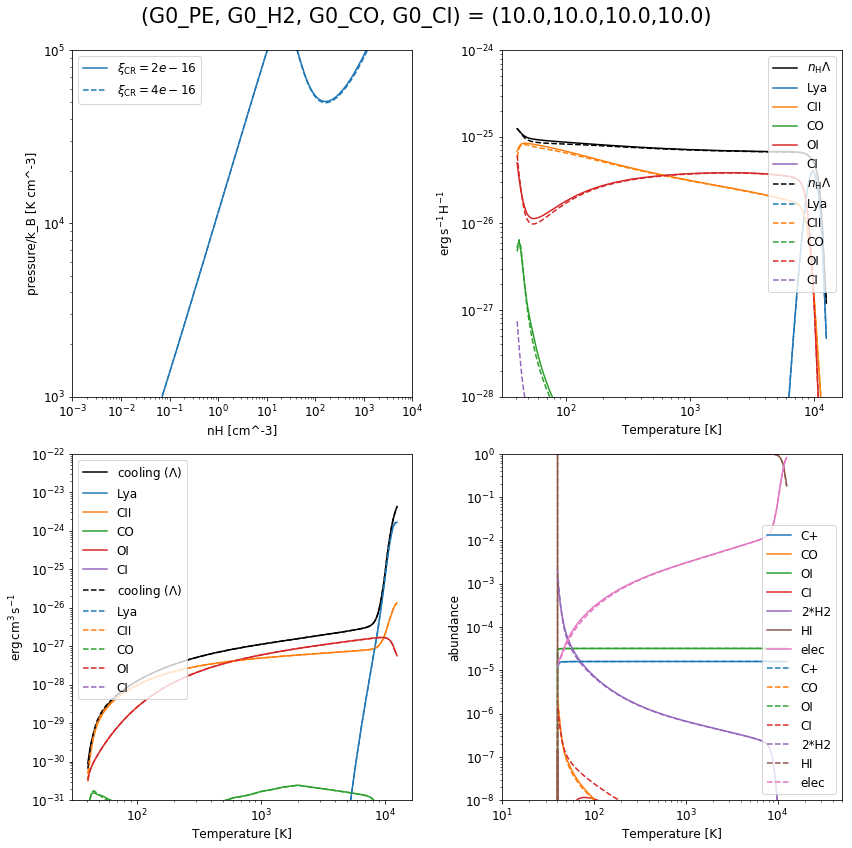

In [10]:
import cool_tigress as ct

Tmin = 10.0
Tmax = 10.0**4.1
T = np.logspace(np.log10(Tmin), np.log10(Tmax), num=200)

par = dict(T=T, Z=0.1, xi_CR=8e-16,
           G_PE=10.0, G_CI=10.0, G_CO=10.0, G_H2=10.0,
           x_e_init=0.03, equil=True, maxiter=200, fast_flag=False)
c1 = ct.CoolTigress(**par)

par.update(fast_flag=True)
c2 = ct.CoolTigress(**par)

mpl.rcParams['font.size'] = 12
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()
plt_all(axes, c1, r'$\xi_{\rm CR}=2e-16$', plt_sty=dict(ls='-'))

for ax in axes:
    plt.sca(ax)
    plt.gca().set_prop_cycle(None)

plt_all(axes, c2, r'$\xi_{\rm CR}=4e-16$',
        plt_sty=dict(ls='--'))
plt.suptitle(#r'$\xi_{\rm H}$=' + str(xi_CR) + 
             r'(G0_PE, G0_H2, G0_CO, G0_CI) = (' + 
             ','.join([str(par['G_PE']),str(par['G_H2']),str(par['G_CO']),str(par['G_CI'])]) + ')',
             fontsize='xx-large')
plt.subplots_adjust(top=0.93)